In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import os
import folium
from folium import Icon
from folium.plugins import HeatMap
import geopandas as gpd
import json
import re
from functools import reduce
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2_contingency

import matplotlib as mpl
mpl.rc('font', family='Malgun Gothic') 
mpl.rcParams['axes.unicode_minus'] = False

In [860]:
!nbqa black 기업EDA.ipynb
!nbqa flake8 EDA.ipynb

reformatted \uae30\uc5c5EDAdz35s05t_nbqa_ipynb.py



All done! \u2728 \U0001f370 \u2728

1 file reformatted.

No such file or directory: EDA.ipynb


In [3]:
point_color = '#e5f5e0'
faded_color = '#238b45'

In [4]:
company_df = pd.read_csv("./company_df.csv")
company_fund_df = pd.read_csv("./company_fund_df.csv")
application_df = pd.read_csv("./application_df.csv")
job_df = pd.read_csv("./job_df.csv")
job_bookmark_df = pd.read_csv("./job_bookmark_df.csv")

In [5]:
# 지원서, 채용공고, 북마크 2022-2023 데이터만 추출
company_df['cdate'] = pd.to_datetime(company_df['cdate'], format="mixed", utc=True)
company_df['mdate'] = pd.to_datetime(company_df['mdate'], format="mixed", utc=True)

job_df['cdate'] = pd.to_datetime(job_df['cdate'], format="mixed", utc=True)
job_df['mdate'] = pd.to_datetime(job_df['mdate'], format="mixed", utc=True)
job_df = job_df[(job_df["cdate"] >= "2021-12-31 15:00:00") & (job_df["cdate"] < "2023-12-31 15:00:00")]
job_df.rename({"cdate": "cdate_job", "mdate": "mdate_job"}, inplace=True, axis=1)
job_bookmark_df['cdate'] = pd.to_datetime(job_bookmark_df['cdate'], format="mixed", utc=True)
job_bookmark_df = job_bookmark_df[(application_df["cdate"] >= "2021-12-31 15:00:00") & (job_bookmark_df["cdate"] < "2023-12-31 15:00:00")]
job_bookmark_df.rename({"cdate": "cdate_bookmark"}, inplace=True, axis=1)

application_df['cdate'] = pd.to_datetime(application_df['cdate'], format="mixed", utc=True)
application_df = application_df[(application_df["cdate"] >= "2021-12-31 15:00:00") & (application_df["cdate"] < "2023-12-31 15:00:00")]
application_df.drop(columns=["Unnamed: 0", "cdate_date", "cdate_hour"], inplace=True)
application_df.rename({"cdate": "cdate_application"}, inplace=True, axis=1)

In [6]:
company_df = company_df.merge(company_fund_df, how="left", on="company_uuid")[[
    "cdate", "mdate", "employee_count", "view_count", "follow_count", "reference_count", "company_uuid", "round_type", "raised", "currency"
]]
company_df.rename({"cdate": "cdate_profile", "mdate": "mdate_profile", "view_count": "view_count_ln"}, inplace=True, axis=1)
# 자연로그 처리된 view count 되돌기기
company_df["view_count"] = np.expm1(company_df["view_count_ln"])

In [7]:
# 공고별 북마크 수
bookmark_count_per_job = job_bookmark_df.groupby("job_uuid")["cdate_bookmark"].count().reset_index(name="bookmark_count_per_job")
job_df = job_df.merge(bookmark_count_per_job, how="left", on="job_uuid").fillna(0)
bookmark_count = job_df.groupby("company_uuid")["bookmark_count_per_job"].sum().reset_index(name="bookmark_count")
bookmark_count

,company_uuid,bookmark_count
0,00027545-e75b-4b62-9d97-02eaa67618e7,0.0
1,00093c2d-5734-4162-82e8-1def2a831408,0.0
2,0009c5b4-eca5-482a-a9a0-3d08e106909d,10.0
3,002c50ee-94fa-402f-bf2c-5c742a34afa0,0.0
4,0035a411-212f-4b0d-b08e-2d3828ed0b0a,9.0
...,...,...
4638,ff9c9388-fb06-49b8-8448-5d87bc064baf,7.0
4639,ffa08937-287f-42ef-bc7f-34ed9daf0745,0.0
4640,ffce5989-097a-4a4d-877e-cfb822fcd80f,0.0
4641,ffd03b2d-e0e9-40b3-83f3-6b5ae0eba6ff,0.0


In [8]:
# 회사별 전체 공고 수
job_post_count = job_df[["job_uuid", "company_uuid"]].groupby("company_uuid")["job_uuid"].count().reset_index(name="job_post_count")
job_post_count.head(2)

,company_uuid,job_post_count
0,00027545-e75b-4b62-9d97-02eaa67618e7,3
1,00093c2d-5734-4162-82e8-1def2a831408,1


In [9]:
# 회사별 지원된 공고 수
applied_post_count = application_df.groupby(["company_uuid"])["job_uuid"].nunique().reset_index(name="applied_post_count")
applied_post_count.head(2)

,company_uuid,applied_post_count
0,00027545-e75b-4b62-9d97-02eaa67618e7,3
1,0009c5b4-eca5-482a-a9a0-3d08e106909d,11


In [10]:
# 회사별 지원공고 비율
post_df = job_post_count.merge(applied_post_count, on="company_uuid", how="left").fillna(0)
post_df["applied_post_rate"] = post_df["applied_post_count"] / post_df["job_post_count"]
post_df.head(2)

,company_uuid,job_post_count,applied_post_count,applied_post_rate
0,00027545-e75b-4b62-9d97-02eaa67618e7,3,3.0,1.0
1,00093c2d-5734-4162-82e8-1def2a831408,1,0.0,0.0


In [11]:
# 회사별 전체 지원 수
total_applications = application_df.groupby("company_uuid")["application_uuid"].count().reset_index(name="total_applications")
total_applications.head(2)

,company_uuid,total_applications
0,00027545-e75b-4b62-9d97-02eaa67618e7,6
1,0009c5b4-eca5-482a-a9a0-3d08e106909d,31


In [12]:
# 최근 채용공고 업데이트 일자
last_job_post_update = job_df.groupby("company_uuid")["cdate_job"].max().reset_index(name="last_job_post_update")
last_job_post_update.head(2)

,company_uuid,last_job_post_update
0,00027545-e75b-4b62-9d97-02eaa67618e7,2022-06-07 04:24:50+00:00
1,00093c2d-5734-4162-82e8-1def2a831408,2022-06-16 08:27:43+00:00


In [13]:
dfs = [company_df, post_df, bookmark_count, total_applications, last_job_post_update]
merged_df = reduce(lambda left, right: left.merge(right, on="company_uuid", how="left"), dfs)
merged_df.fillna({
    "job_post_count": 0,
    "total_applications": 0,
    "bookmark_count": 0,
    "applied_post_rate": 0,
    "last_job_post_update": pd.NaT
}, inplace=True)

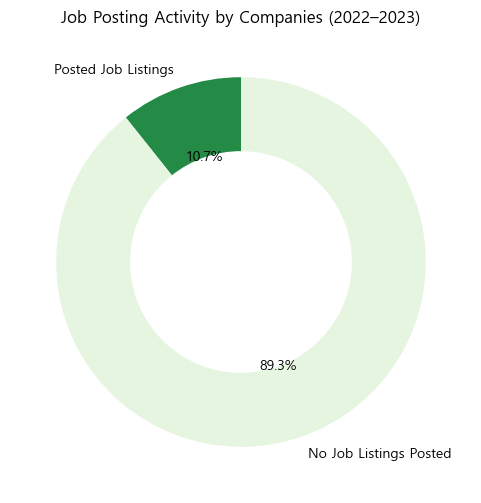

In [14]:
# 문제점 인식 - 현재 플랫폼에 등록된 전체 회사 중 약 10%만 2022-2023년 사이에 채용공고를 적어도 한번 올렸다.

labels = ['Posted Job Listings', 'No Job Listings Posted']
sizes = [len(merged_df[merged_df["job_post_count"] != 0]),
         len(merged_df[merged_df["job_post_count"] == 0])]

colors = [faded_color, point_color]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops=dict(width=0.4))
plt.title('Job Posting Activity by Companies (2022–2023)')
plt.show()

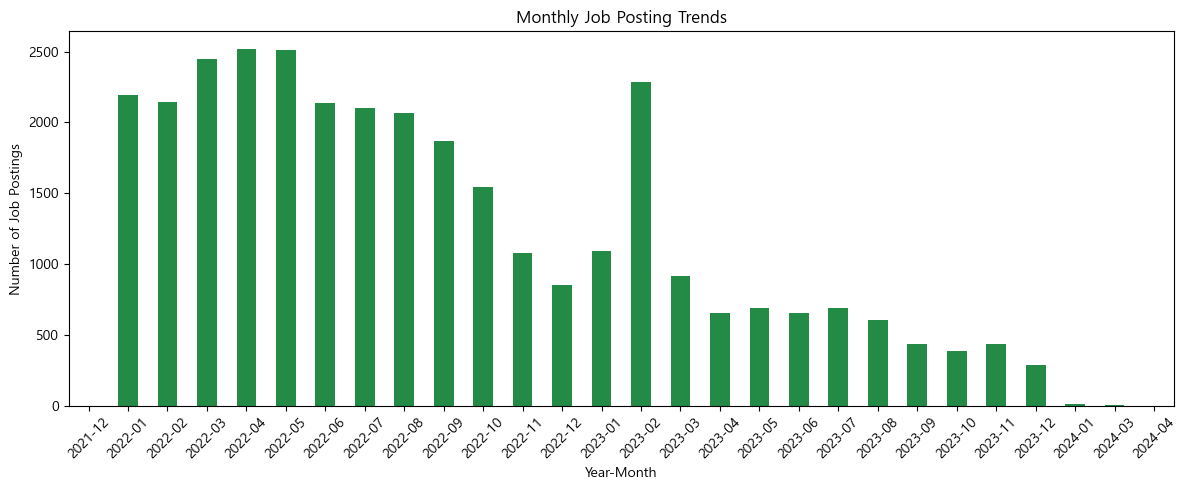

In [15]:
# 문제점 인식 - 채용공고 수가 2022년도에 비해 2023년도에 확연히 (약 61%) 감소함.
job_df["start_date"] = pd.to_datetime(job_df["start_date"])
job_df["year"] = job_df["start_date"].dt.year
job_df["year_month"] = job_df["start_date"].dt.to_period("M").astype(str)
yearly_counts = job_df["year"].value_counts().sort_index()
monthly_counts = job_df["year_month"].value_counts().sort_index()

monthly_counts.plot(kind="bar", figsize=(12, 5), color=faded_color)
plt.title("Monthly Job Posting Trends")
plt.xlabel("Year-Month")
plt.ylabel("Number of Job Postings")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

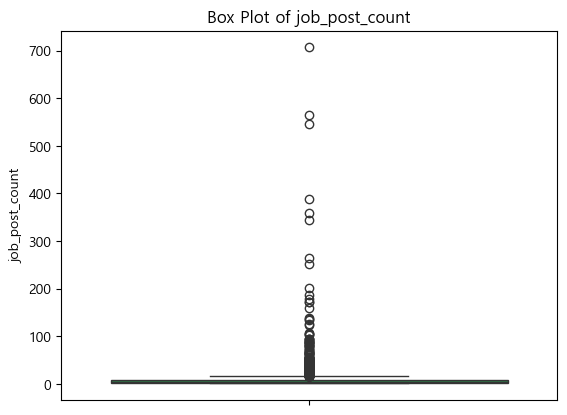

In [16]:
# 채용공고를 2년간 700개씩 내는 회사가 있을까? 전체 직원수가 501-1000명인데 ..
# 전체 채용공고 수 대비 지원서 제출 비율은 약 11.4%에 불과함
sns.boxplot(data=job_post_count["job_post_count"], color=faded_color)
plt.title('Box Plot of job_post_count')
plt.show()

### 세그먼테이션 분석

In [786]:
# 채용공고를 한번이라도 게시한 회사만 추림
active_company_df = merged_df[merged_df["job_post_count"]>0]

In [788]:
reference_date = active_company_df['last_job_post_update'].max()
active_company_df['recency'] = (reference_date - active_company_df['last_job_post_update']).dt.days

In [790]:
# 등급 나누기
num_grades = 3
grade_labels = list(range(1, num_grades+1))

In [800]:
def safe_qcut(series, q, labels):
    try:
        bins = pd.qcut(series, q=q, duplicates='drop')
        if bins.cat.categories.size != len(labels):
            bins = pd.qcut(series, q=q+1, labels=labels, duplicates='drop')
        else:
            bins = pd.qcut(series, q=q, labels=labels)
        return bins.astype(float)
    except Exception as e:
        return pd.Series([np.nan] * len(series), index=series.index)
        
active_company_df["recency_score"] = safe_qcut(active_company_df["recency"], num_grades, grade_labels[::-1])
active_company_df["applied_post_rate_score"] = safe_qcut(active_company_df["applied_post_rate"], num_grades, grade_labels)
active_company_df["bookmark_count_score"] = safe_qcut(active_company_df["bookmark_count"], num_grades, grade_labels)
active_company_df["follow_count_score"] = safe_qcut(active_company_df["follow_count"], num_grades, grade_labels)
active_company_df["reference_count_score"] = safe_qcut(active_company_df["reference_count"], num_grades, grade_labels)
active_company_df["view_count_score"] = safe_qcut(active_company_df["view_count"], num_grades, grade_labels)
active_company_df["total_applications_score"] = safe_qcut(active_company_df["total_applications"], num_grades, grade_labels)

active_company_df["rfm_score"] = (
    active_company_df["recency_score"]
    + active_company_df["applied_post_rate_score"] * 1.1
    + active_company_df["bookmark_count_score"]
    + active_company_df["follow_count_score"]
    + active_company_df["reference_count_score"]
    + active_company_df["view_count_score"]
    + active_company_df["total_applications_score"]
)

In [826]:
active_company_df['rank'] = active_company_df['rfm_score'].rank(method='first', ascending=False).astype(int)

def assign_grade(rank):
    if rank <= 50:
        return 'Top50'
    elif rank <= 100:
        return 'Top100'
    else:
        return '일반'

active_company_df['rfm_segment'] = active_company_df['rank'].apply(assign_grade)

In [828]:
inactive_company_df = merged_df[merged_df["job_post_count"]<=0]
inactive_company_df["rfm_segment"] = "일반"
total_df = pd.concat([active_company_df, inactive_company_df])

In [832]:
total_df['rfm_segment'].value_counts()

rfm_segment
일반        41559
Top100       50
Top50        50
Name: count, dtype: int64

In [834]:
groupby_rfm_segment = total_df.groupby('rfm_segment').mean(numeric_only=True).reset_index()
rfm_order = ["Top50", "Top100", "일반"]
groupby_rfm_segment["rfm_segment"] = pd.Categorical(groupby_rfm_segment["rfm_segment"], categories=rfm_order, ordered=True)
groupby_rfm_segment = groupby_rfm_segment.sort_values(by="rfm_segment").rename(columns={"rfm_segment":"group"}).reset_index()

In [836]:
groupby_rfm_segment[["group", "job_post_count", "recency","applied_post_rate","bookmark_count","follow_count","reference_count","view_count","total_applications","rfm_score","rank"]]

,group,job_post_count,recency,applied_post_rate,bookmark_count,follow_count,reference_count,view_count,total_applications,rfm_score,rank
0,Top50,9.240000,189.700000,1.524712,24.020000,443.860000,20.920000,25581.700000,154.900000,21.300000,25.5
1,Top100,9.100000,313.260000,1.615441,12.860000,313.240000,13.880000,12180.500000,106.800000,20.290000,75.5
2,일반,0.752617,421.016735,0.067361,0.427152,9.282851,0.701364,1620.341154,1.847205,13.024163,2281.5


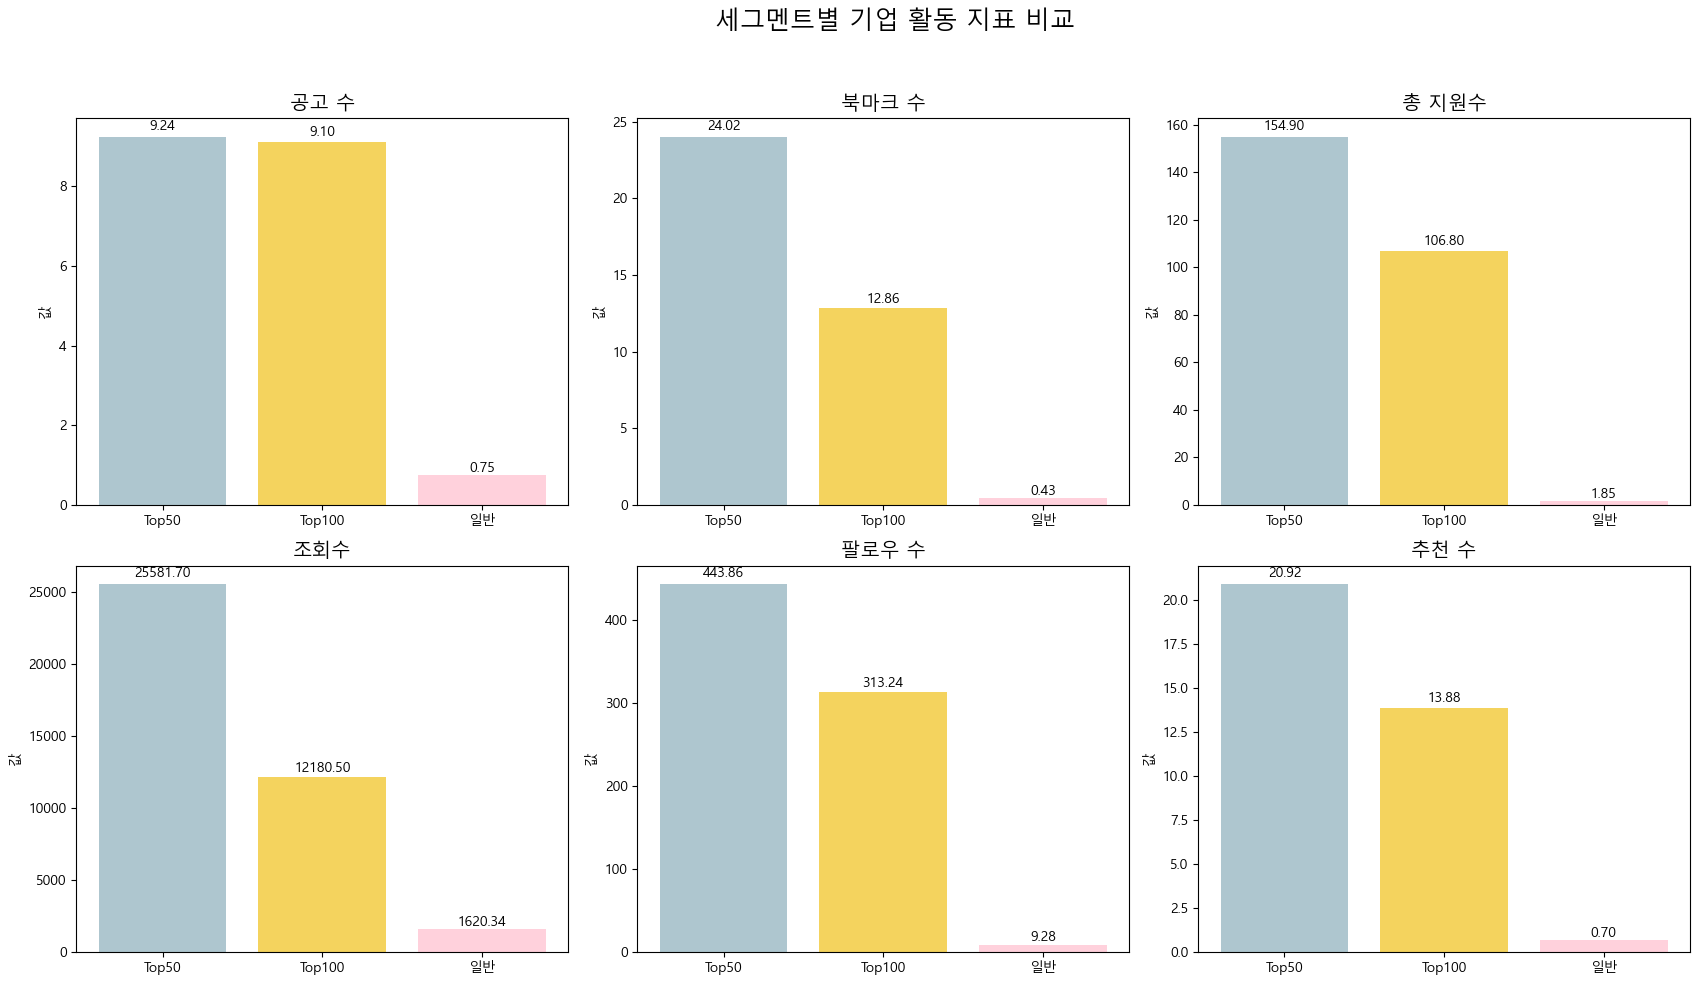

In [858]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('세그멘트별 기업 활동 지표 비교', fontsize=18)

metrics = {
    'job_post_count': '공고 수',
    'bookmark_count': '북마크 수',
    'total_applications': '총 지원수',
    'view_count': '조회수',
    'follow_count': '팔로우 수',
    'reference_count': '추천 수'
}
colors = ["#AEC6CF", "#F4D35E", "#FFD1DC"]

for ax, (metric, title) in zip(axes.flatten(), metrics.items()):
    ax.bar(groupby_rfm_segment['group'], groupby_rfm_segment[metric], color=colors)
    ax.set_title(title, fontsize=14)
    ax.set_ylabel('값')
    ax.set_xlabel('')
    
    for i, val in enumerate(groupby_rfm_segment[metric]):
        ax.text(i, val * 1.01, f'{val:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout(rect=[0, 0, 0.95, 0.95])
plt.show()

In [457]:
top_company_df = active_company_df[active_company_df["rfm_segment"].eq("Top50")]
len(top_company_df)

50

In [459]:
# Top50 기업은 평균 9.24개의 채용공고를 게시함
top_company_df["job_post_count"].mean()

np.float64(9.24)

In [461]:
# 전체 기업은 평균적으로 채용공고를 0.77개 게시 -> 대다수 기업이 플랫폼 내에서 거의 활동하지 않거나, 한두 번만 시도해 본 수준
merged_df["job_post_count"].mean()

np.float64(0.7728221992846683)

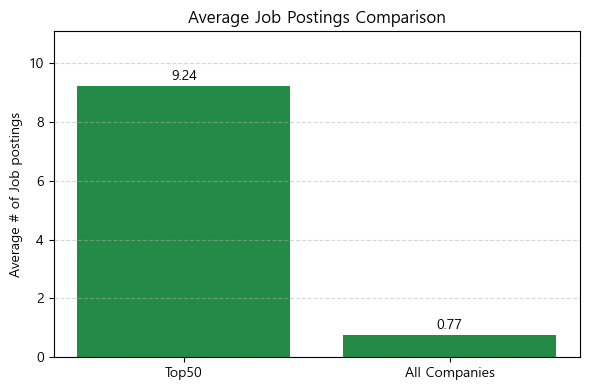

In [463]:
gold_avg = top_company_df["job_post_count"].mean()
total_avg = merged_df["job_post_count"].mean()

labels = ["Top50", "All Companies"]
values = [gold_avg, total_avg]

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, values, color=faded_color)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.1, f"{height:.2f}", 
             ha='center', va='bottom', fontsize=10)

plt.title("Average Job Postings Comparison")
plt.ylabel("Average # of Job postings")
plt.ylim(0, max(values) * 1.2)
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.tight_layout()

plt.show()

### top50 기업 특성 파악하기
1. 직원 수
2. 투자 단계
3. 자주 올리는 채용공고 job field/경력
4. 경력수준
5. 재택 여부
6. 연봉 공개 여부

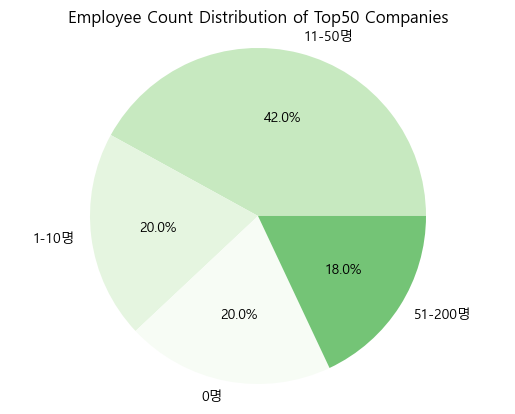

In [31]:
color_map = {
    '0명': '#f7fcf5',
    '1-10명': '#e5f5e0',
    '11-50명': '#c7e9c0',
    '51-200명': '#74c476',
    '201-500명': '#41ab5d',
    '501-1000명': '#238b45',
    '1001-5000명': '#006d2c',
    '5000명 초과': '#00441b'
}
employee_counts = top_company_df["employee_count"].value_counts()
labels = employee_counts.index
sizes = employee_counts.values

colors = [color_map[label] for label in labels]

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title("Employee Count Distribution of Top50 Companies")
plt.axis('equal')
plt.show()

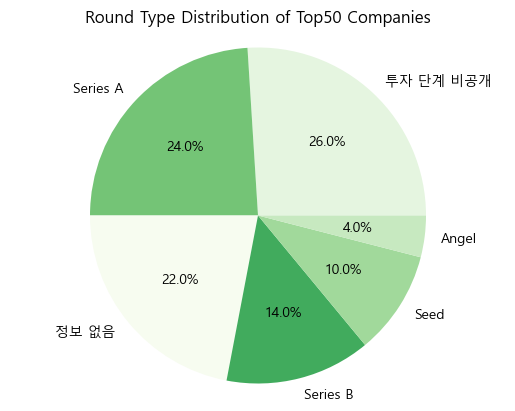

In [32]:
color_map = {
    '정보 없음': '#f7fcf0', 
    '해당없음': '#f7fcf5',
    '투자 단계 비공개': '#e5f5e0',
    'Angel': '#c7e9c0',
    'Seed': '#a1d99b',
    'Series A': '#74c476',
    'Series B': '#41ab5d',
    'Series C': '#238b45',
    'Series D': '#006d2c',
    'Pre-IPO': '#00441b'
}
top_company_df['round_type'] = top_company_df['round_type'].fillna('정보 없음') 
employee_counts = top_company_df["round_type"].value_counts()
labels = employee_counts.index
sizes = employee_counts.values

colors = [color_map[label] for label in labels]

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title("Round Type Distribution of Top50 Companies")
plt.axis('equal')
plt.show()

In [33]:
top_company_job_df = top_company_df.merge(job_df, on="company_uuid", how="left")

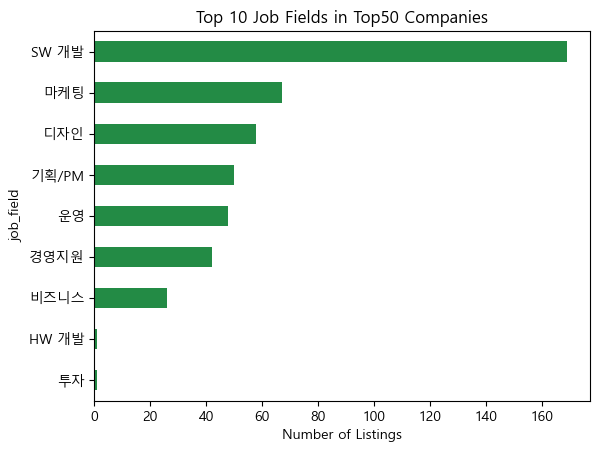

In [34]:
# Top 50 기업이 게시한 채용공고 중 약 38.1%는 소프트웨어 개발(SW 개발) 직무에 집중됨
top_fields = top_company_job_df["job_field"].value_counts().head(10)
top_fields.plot(kind="barh", color=faded_color)
plt.title("Top 10 Job Fields in Top50 Companies")
plt.xlabel("Number of Listings")
plt.gca().invert_yaxis()
plt.show()

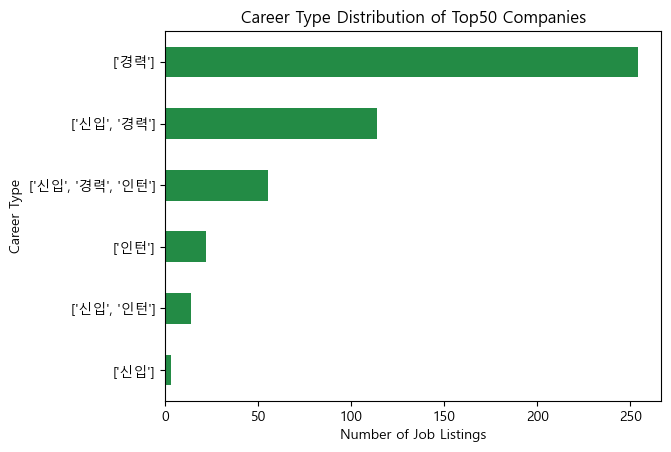

In [35]:
# Top 50 기업의 채용공고 중 약 54.9%는 경력자만을 대상
#신입과 인턴을 모두 고려한 공고도 일부 존재하지만, 경력직 중심의 채용이 뚜렷한 경향을 보임
top_company_job_df["career_type_string"].value_counts().plot(kind="barh", color=faded_color)
plt.title("Career Type Distribution of Top50 Companies")
plt.xlabel("Number of Job Listings")
plt.ylabel("Career Type")
plt.gca().invert_yaxis()
plt.show()

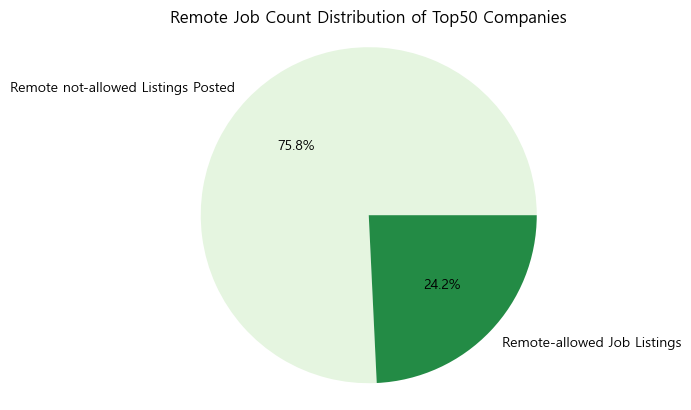

In [36]:
job_counts = top_company_job_df["allow_remote"].value_counts()
labels = ['Remote not-allowed Listings Posted', 'Remote-allowed Job Listings',]
sizes = job_counts.values

colors = [point_color, faded_color]

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title("Remote Job Count Distribution of Top50 Companies")
plt.axis('equal')
plt.show()

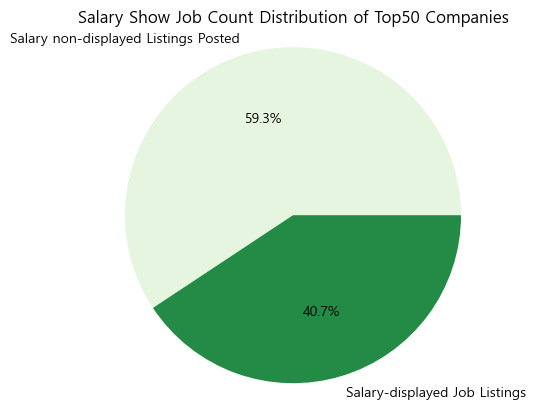

In [37]:
job_counts = top_company_job_df["can_show_salary"].value_counts()
labels = ['Salary non-displayed Listings Posted', 'Salary-displayed Job Listings',]
sizes = job_counts.values

colors = [point_color, faded_color]

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title("Salary Show Job Count Distribution of Top50 Companies")
plt.axis('equal')
plt.show()

In [842]:
top50 = total_df[total_df["rfm_segment"].eq("Top50")].company_uuid.to_list()
top100 = total_df[total_df["rfm_segment"].eq("Top100")].company_uuid.to_list()
total = total_df.company_uuid.to_list()
rest = total_df[total_df["rfm_segment"].eq("일반")].company_uuid.to_list()

In [844]:
company_counts = job_df[job_df["company_uuid"].isin(top50)]
application_counts = application_df[application_df["company_uuid"].isin(top50)]
print("기준 월 공고 기업 수 in top50: ", company_counts[(company_counts["start_date"]>="2023-08-01") & (company_counts["start_date"]<="2023-08-31")].sort_values(by="start_date").company_uuid.nunique())
print("2개월 후 공고 기업 수 in top50: ", company_counts[(company_counts["start_date"]>="2023-10-01") & (company_counts["start_date"]<="2023-10-31")].sort_values(by="start_date").company_uuid.nunique())
print("월간 평균 공고 등록 수: ", application_counts[(application_counts["cdate_application"]>="2023-08-01") & (application_counts["cdate_application"]<="2023-10-31")].job_uuid.nunique() /2/len(top50))
print("월간 평균 유저 지원 수: ", application_counts[(application_counts["cdate_application"]>="2023-08-01") & (application_counts["cdate_application"]<="2023-10-31")].application_uuid.nunique() /2/len(top50))

기준 월 공고 기업 수 in top50:  9
2개월 후 공고 기업 수 in top50:  7
월간 평균 공고 등록 수:  1.11
월간 평균 유저 지원 수:  8.48


In [846]:
company_counts = job_df[job_df["company_uuid"].isin(top100)]
application_counts = application_df[application_df["company_uuid"].isin(top100)]
print("기준 월 공고 기업 수 in top100: ", company_counts[(company_counts["start_date"]>="2023-08-01") & (company_counts["start_date"]<="2023-08-31")].sort_values(by="start_date").company_uuid.nunique())
print("2개월 후 공고 기업 수 in top100: ", company_counts[(company_counts["start_date"]>="2023-10-01") & (company_counts["start_date"]<="2023-10-31")].sort_values(by="start_date").company_uuid.nunique())
print("월간 평균 공고 등록 수: ", application_counts[(application_counts["cdate_application"]>="2023-08-01") & (application_counts["cdate_application"]<="2023-10-31")].job_uuid.nunique() /2/len(top100))
print("월간 평균 유저 지원 수: ", application_counts[(application_counts["cdate_application"]>="2023-08-01") & (application_counts["cdate_application"]<="2023-10-31")].application_uuid.nunique() /2/len(top100))

기준 월 공고 기업 수 in top100:  2
2개월 후 공고 기업 수 in top100:  3
월간 평균 공고 등록 수:  0.38
월간 평균 유저 지원 수:  4.27


In [848]:
company_counts = job_df[job_df["company_uuid"].isin(rest)]
application_counts = application_df[application_df["company_uuid"].isin(rest)]
print("기준 월 공고 기업 수 in 일반: ", company_counts[(company_counts["start_date"]>="2023-08-01") & (company_counts["start_date"]<="2023-08-31")].sort_values(by="start_date").company_uuid.nunique())
print("2개월 후 공고 기업 수 in 일반: ", company_counts[(company_counts["start_date"]>="2023-10-01") & (company_counts["start_date"]<="2023-10-31")].sort_values(by="start_date").company_uuid.nunique())
print("월간 평균 공고 등록 수: ", application_counts[(application_counts["cdate_application"]>="2023-08-01") & (application_counts["cdate_application"]<="2023-10-31")].job_uuid.nunique() /2/len(rest))
print("월간 평균 유저 지원 수: ", application_counts[(application_counts["cdate_application"]>="2023-08-01") & (application_counts["cdate_application"]<="2023-10-31")].application_uuid.nunique() /2/len(rest))

기준 월 공고 기업 수 in 일반:  237
2개월 후 공고 기업 수 in 일반:  171
월간 평균 공고 등록 수:  0.01864818691498833
월간 평균 유저 지원 수:  0.10333501768569985


In [849]:
company_counts = job_df[job_df["company_uuid"].isin(total)]
application_counts = application_df[application_df["company_uuid"].isin(total)]
print("기준 월 공고 기업 수 in 전체: ", company_counts[(company_counts["start_date"]>="2023-08-01") & (company_counts["start_date"]<="2023-08-31")].sort_values(by="start_date").company_uuid.nunique())
print("2개월 후 공고 기업 수 in 전체: ", company_counts[(company_counts["start_date"]>="2023-10-01") & (company_counts["start_date"]<="2023-10-31")].sort_values(by="start_date").company_uuid.nunique())
print("월간 평균 공고 등록 수: ", application_counts[(application_counts["cdate_application"]>="2023-08-01") & (application_counts["cdate_application"]<="2023-10-31")].job_uuid.nunique() /2/len(total))
print("월간 평균 유저 지원 수: ", application_counts[(application_counts["cdate_application"]>="2023-08-01") & (application_counts["cdate_application"]<="2023-10-31")].application_uuid.nunique() /2/len(total))

기준 월 공고 기업 수 in 전체:  248
2개월 후 공고 기업 수 in 전체:  181
월간 평균 공고 등록 수:  0.02039175208238316
월간 평균 유저 지원 수:  0.11838978372020452
